Loading and Plotting surface EMG Data
=====================================

Here we show how to load and visualize EMG data collected at the wrist as described in the paper ["A generic noninvasive neuromotor interface for human-computer interaction"](https://www.biorxiv.org/content/10.1101/2024.02.23.581779v1.full.pdf). We will show examples from each of the three tasks described in the paper: `discrete_gestures`, `handwriting`, and `wrist_angles`.

# Setup

First download the data, as described in the `README`. If necessary, set the `root_data_folder` below to the location of the files.

In [1]:
%load_ext autoreload
%autoreload 2


from neuromotor_data_loading.plot import plot_emg, plot_wrist
from neuromotor_data_loading.load import load_data
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import glob
import os


root_data_folder = "~/emg_data/"


def get_task_files(root_data_folder: str, task: str):
    """Get all hdf5 files for a given task (discrete_gestures, handwriting, or wrist_angles)."""
    task_folder = os.path.join(os.path.expanduser(root_data_folder), task)
    return glob.glob(os.path.join(task_folder, '*.hdf5'))

# Loading data

Next we'll select one of the `discrete_gesture` files.

In [2]:
file = get_task_files(root_data_folder, "discrete_gestures")[0]
print("Selected file:", os.path.basename(file))

Selected file: discrete_gestures_dataset_2.hdf5


We'll load the file using the `load_data` utility function.

In [3]:
data = load_data(file)
data

The file contains EMG, timestamps, a task identifier, a `prompts` dataframe with the timing of all the gestures, and a `stages` dataframe with the timing of the different experimental stages.

In [4]:
print("task:            ", data.task)
print("emg shape:       ", data.emg.shape)
print("timestamp shape: ", data.time.shape)
print("stages:")
display(data.stages.head())
print("prompts:")
display(data.prompts)

task:             discrete_gestures
emg shape:        (3982280, 16)
timestamp shape:  (3982280,)
stages:


,start,end,name
0,170.600103,202.062016,pinch_practice
1,223.467273,322.876191,pnr_static_hand_in_lap_with_taps
2,372.746787,396.356239,thumb_swipes_practice
3,415.690301,489.586205,thumb_swipes_static_arm_in_lap
4,489.590914,570.633844,thumb_swipes_static_arm_front


prompts:


,name,time
0,middle_press,242.561392
1,middle_release,242.696450
2,middle_press,242.831435
3,middle_release,242.966421
4,middle_press,243.921546
...,...,...
1168,thumb_down,1629.638342
1169,thumb_in,1630.233272
1170,thumb_in,1630.713266
1171,thumb_up,1631.288250


Data are similarly structured for the `handwriting` datasets. However, the dataframe now encodes the start and end times of each text prompt. Right and left arrows correspond to spaces and backspaces, respectively, and the hand emoji indicates a finger pinch.

In [5]:
file = get_task_files(root_data_folder, "handwriting")[0]
data = load_data(file)

print("task:            ", data.task)
print("emg shape:       ", data.emg.shape)
print("timestamp shape: ", data.time.shape)
print("stages:")
display(data.stages.head())
print("prompts:")
display(data.prompts)

task:             handwriting
emg shape:        (862736, 16)
timestamp shape:  (862736,)
stages:


,start,end,name,posture
0,14.739891,18.853792,characters_with_digits,seated-on-surface
1,18.855604,20.444441,characters_with_digits,seated-on-surface
2,20.446048,22.121153,characters_with_digits,seated-on-surface
3,22.122626,24.107315,characters_with_digits,seated-on-surface
4,24.109223,25.711914,characters_with_digits,seated-on-surface


prompts:


,prompt,start,end
0,2,14.740174,18.854585
1,c,18.855828,20.445117
2,4,20.447128,22.122112
3,m,22.122807,24.109006
4,z,24.109580,25.712772
...,...,...,...
88,a dry suit is🤏,403.180954,409.509683
89,"similar to a wetsuit,🤏",409.523765,412.400010
90,ik←t has also been🤏,412.415539,418.104581
91,the→ advantage→ of→ printmaking🤏,418.105861,421.051188


The `wrist_angles` datasets do not have a `prompts` dataframe. Instead, they have an additional stream of `wrist_angles` data.

In [6]:
file = get_task_files(root_data_folder, "wrist_angles")[0]
data = load_data(file)

print("task:               ", data.task)
print("emg shape:          ", data.emg.shape)
print("wrist_angles shape: ", data.wrist_angles.shape)
print("timestamp shape:    ", data.time.shape)
print("stages:")
display(data.stages.head())

task:                wrist_angles
emg shape:           (3482132, 16)
wrist_angles shape:  (3482132, 2)
timestamp shape:     (3482132,)
stages:


,start,end,name
0,238.261571,397.048199,open_loop_task
1,417.852547,427.867661,hold_neutral_wrist_angle
2,437.469005,448.406154,clockwise_wrist_circles
3,448.407347,459.982409,counterclockwise_wrist_circles
4,459.985924,477.503719,flexions_and_extensions


# Plotting data

## Discrete Gestures

Here we plot EMG snippets for a single `discrete_gesture` dataset in 1 second windows centered on different gesture types.

Notice the use of `gesture_data.partition(start_time, end_time)` to extract windows of EMG around events of interest.

In [7]:
gesture_file = get_task_files(root_data_folder, "discrete_gestures")[0]
gesture_data = load_data(gesture_file)

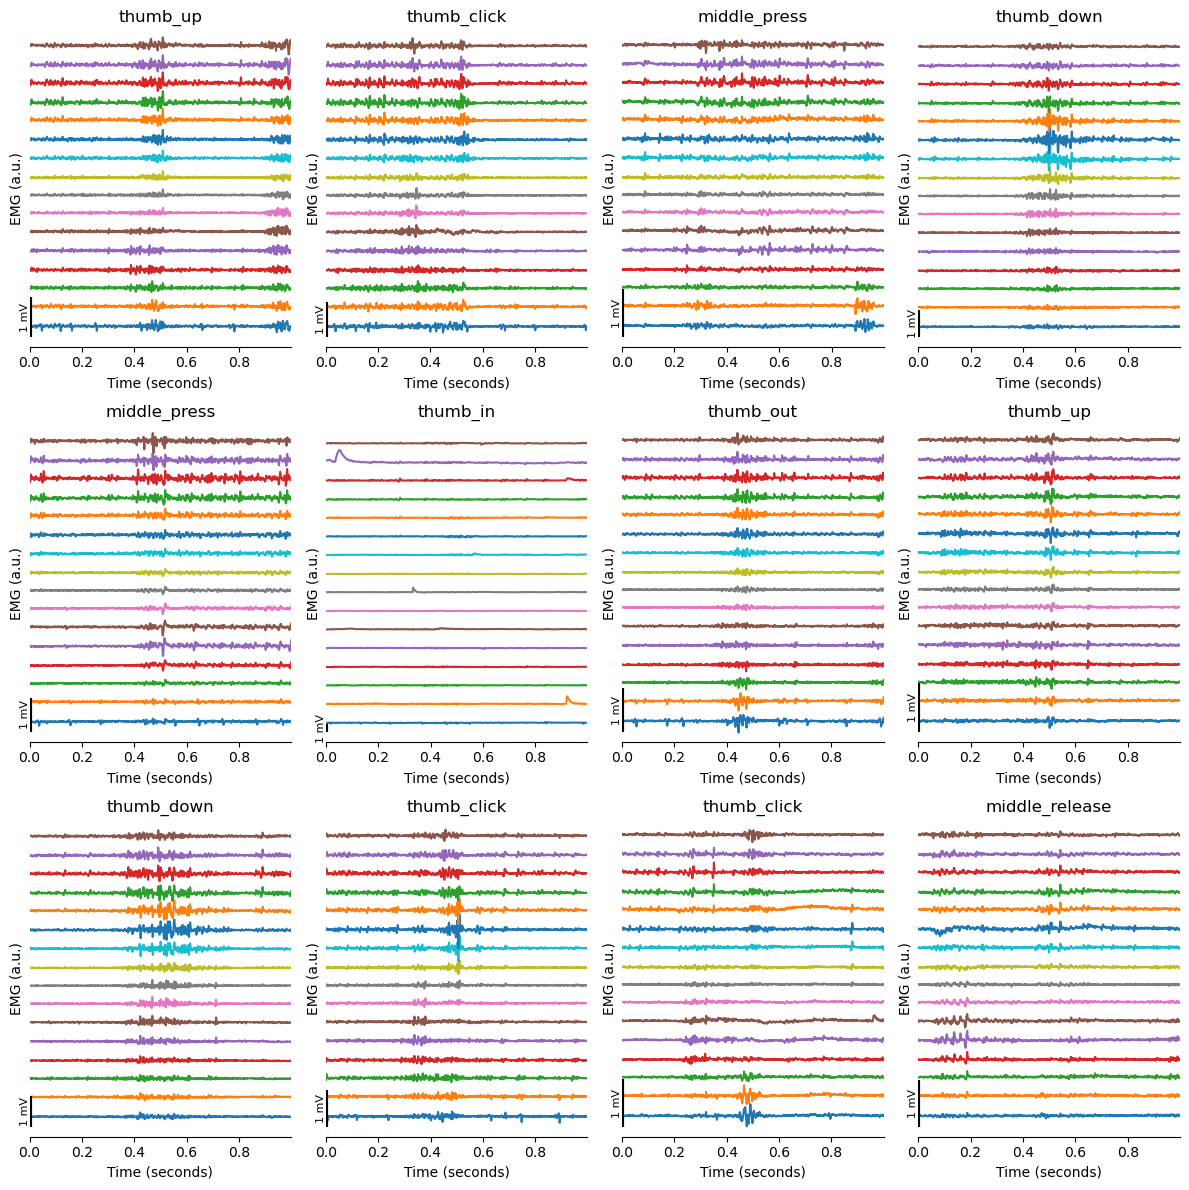

In [8]:
window = [-.5, .5]
nrows = 3
ncols = 4

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 4))

# Sample random gestures
gestures = gesture_data.prompts.sample(nrows * ncols, random_state=0, replace=False)

for ax, (_, gesture) in zip(axs.flatten(), gestures.iterrows()):
    timeseries = gesture_data.partition(gesture.time + window[0], gesture.time + window[1])
    plot_emg(timeseries["time"], timeseries["emg"], ax=ax)
    gesture_name = gesture.loc["name"]
    ax.set(title=f"{gesture_name}")

plt.tight_layout()

## Handwriting

Now we plot snippets of `handwriting` EMG corresponding to individual text prompts. Each snippet begins when the prompt first appears, and ends when the participant finishes writing the prompt.

In [9]:
handwriting_file = get_task_files(root_data_folder, "handwriting")[0]
handwriting_data = load_data(handwriting_file)

In [10]:
handwriting_data.time

array([0.00000000e+00, 4.99963760e-04, 9.99927521e-04, ...,
       4.31447972e+02, 4.31448472e+02, 4.31448972e+02])

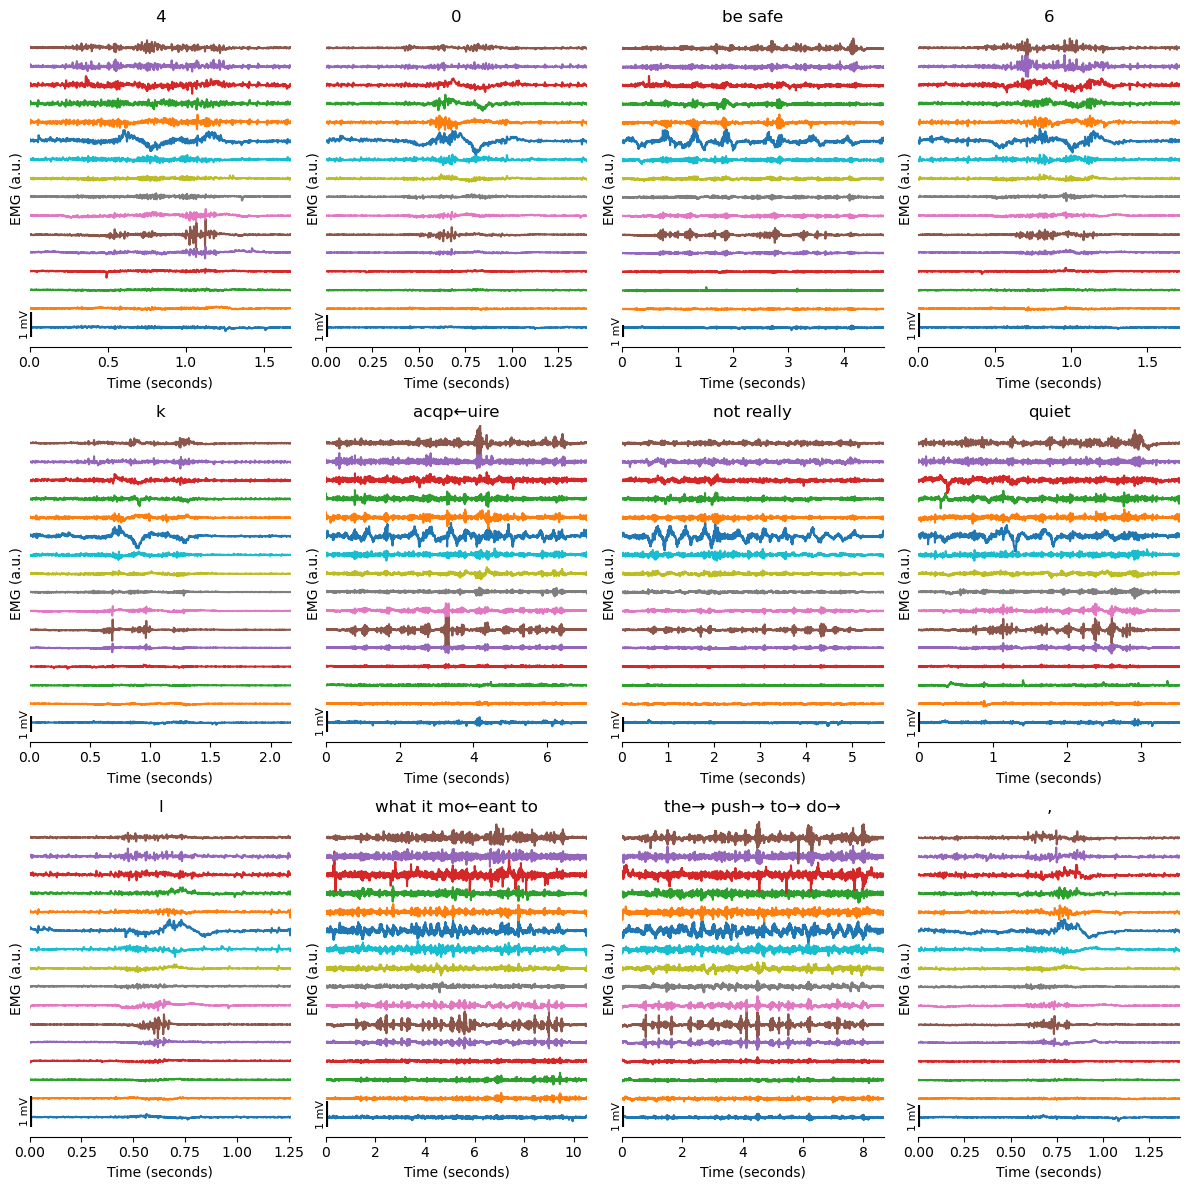

In [11]:
nrows = 3
ncols = 4

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 4))

# Sample random prompts
prompts = handwriting_data.prompts.sample(nrows * ncols, random_state=0, replace=False)

for ax, (_, prompt) in zip(axs.flatten(), prompts.iterrows()):
    timeseries = handwriting_data.partition(prompt.start, prompt.end)
    plot_emg(timeseries["time"], timeseries["emg"], ax=ax)
    ax.set(title=f"{prompt.prompt}")

plt.tight_layout()

## Wrist angles

Finally, we'll plot EMG and wrist angles side-by-side for a few example stages from a `wrist_angles` dataset.

In [12]:
wrist_file = get_task_files(root_data_folder, "wrist_angles")[0]
wrist_data = load_data(wrist_file)

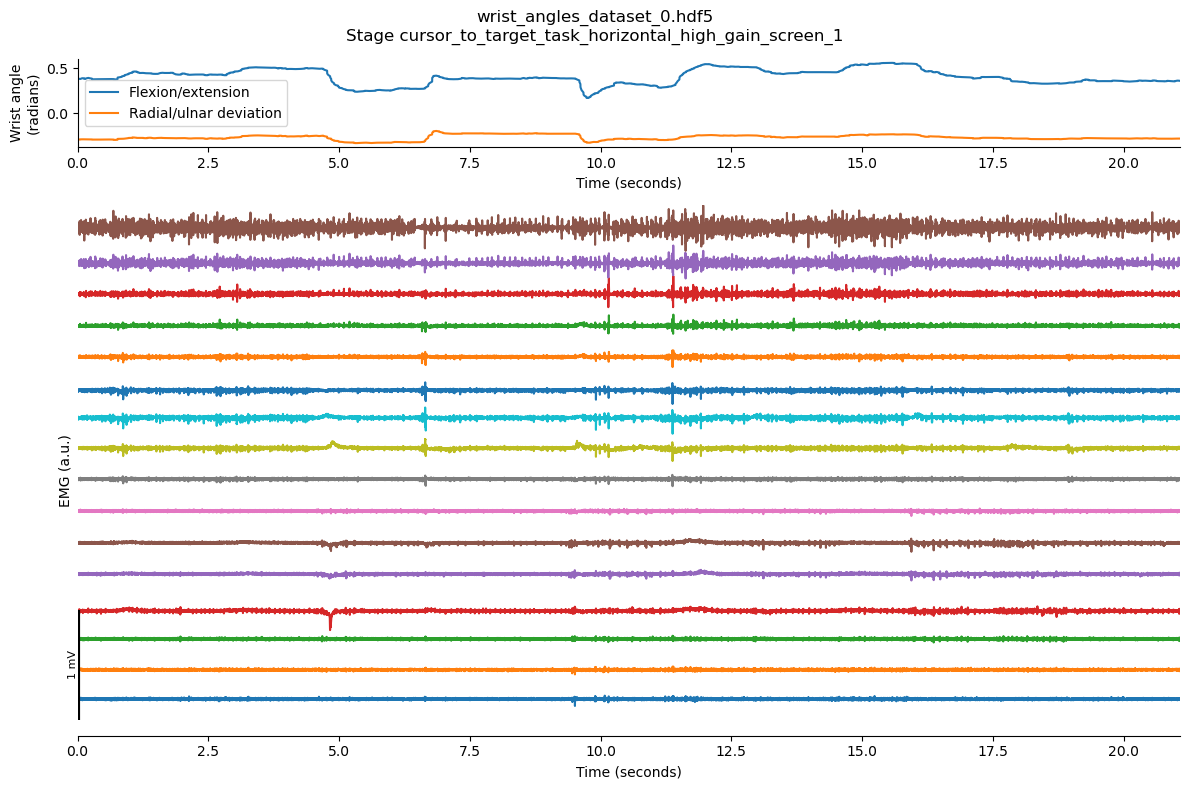

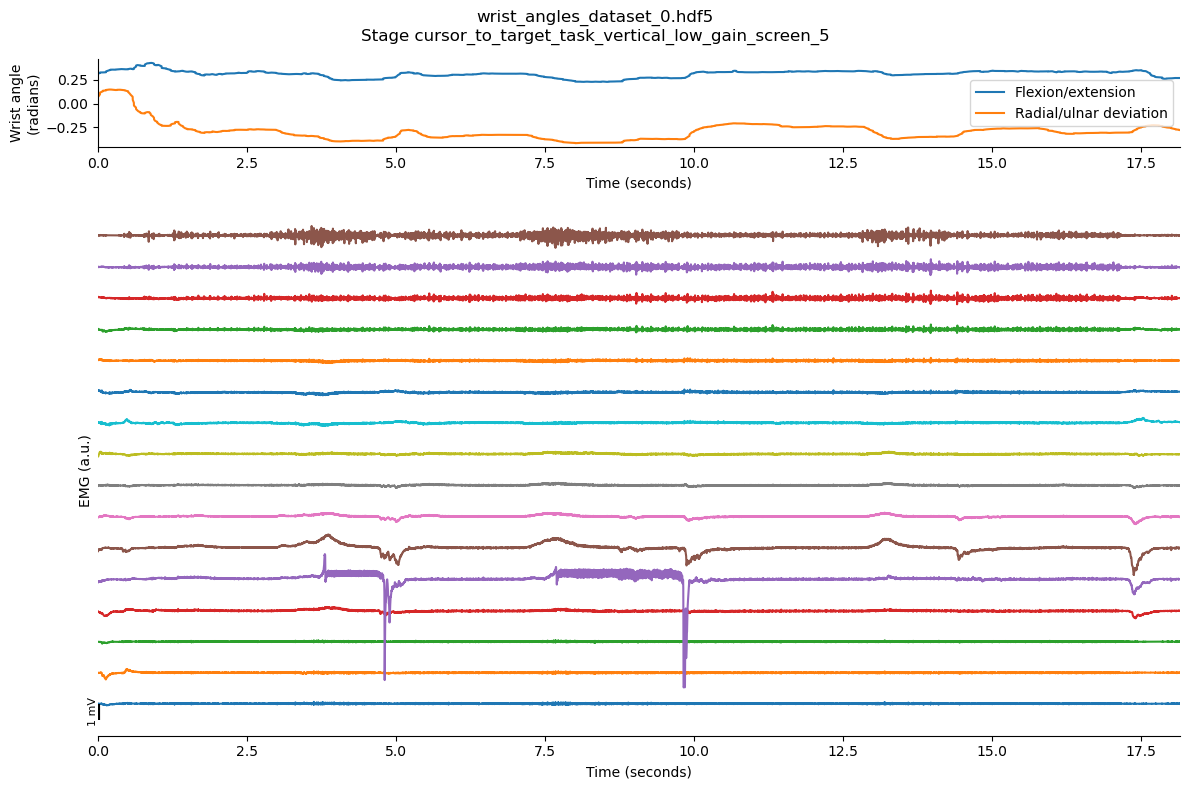

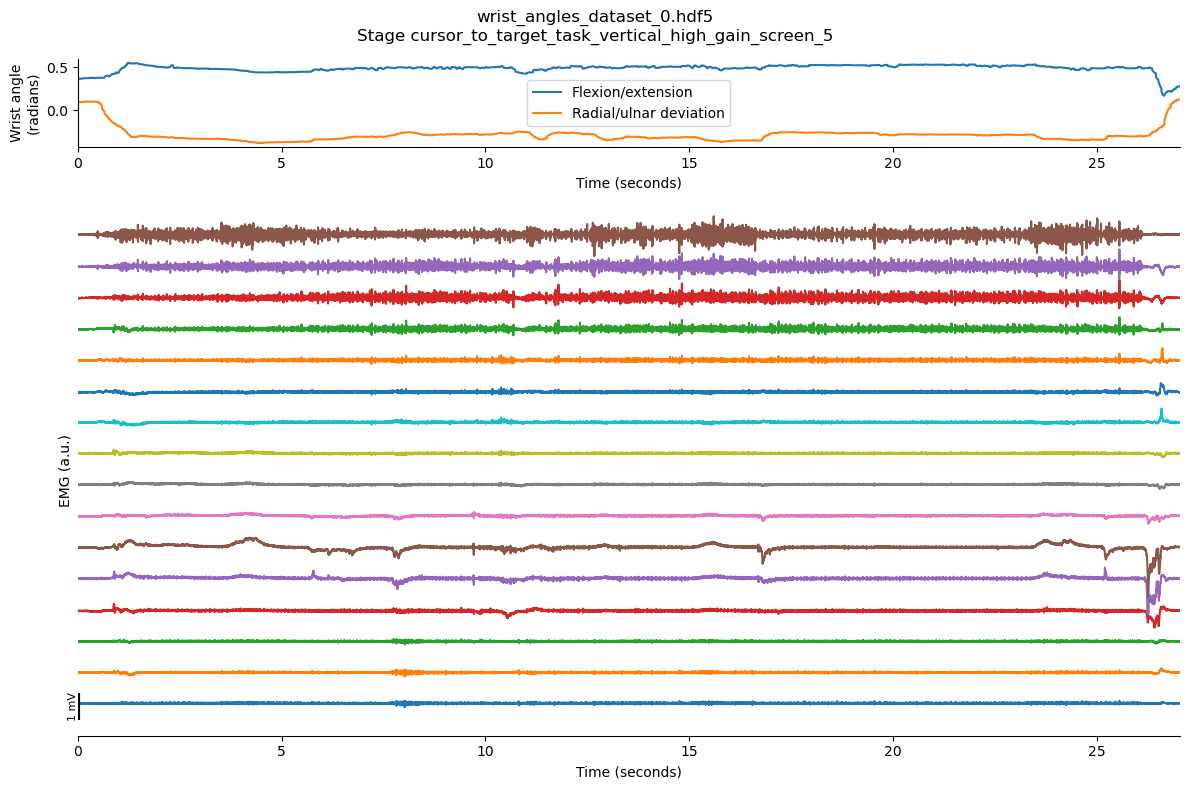

In [14]:
num_stages = 3

# Sample random stages
stages = wrist_data.stages.sample(num_stages, random_state=0, replace=False)

for _, stage in stages.iterrows():
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={"height_ratios": [1, 6]})
    timeseries = wrist_data.partition(stage.start, stage.end)
    
    plot_wrist(timeseries["time"], timeseries["wrist_angles"], ax=axs[0])
    plot_emg(timeseries["time"], timeseries["emg"], ax=axs[1])

    fig.suptitle(f"{os.path.basename(wrist_file)}\nStage {stage['name']}")
    plt.tight_layout()